In [2]:
import torch
import matplotlib as mpl
import os
%matplotlib widget
cmap = mpl.colormaps['viridis']
from tqdm.autonotebook import tqdm
from IPython.display import display
import h5py
import numpy as np
from torch.utils.data import DataLoader
from BasisConvolution.test_case_I.io import loadFile
from BasisConvolution.test_case_I.ablation import trainRBFNetwork
from BasisConvolution.test_case_I.dataset import loadTestcase
from BasisConvolution.test_case_I.eval import getTestingLossFrame
from BasisConvolution.test_case_I.train import trainModel
from BasisConvolution.test_case_I.util import getStackedUpdates, lossFunction, getGroundTruthKernel, getGroundTruthKernelGradient, getGroundTruthPhysics, getFeaturesKernel, getFeaturesPhysics
import pandas as pd

/tmp/ipykernel_206974/3735487597.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
trainingFiles = ['../../datasets/test_case_I/' + f for f in os.listdir('../../datasets/test_case_I/') if f.endswith('.hdf5')]

In [4]:
# Load generic settings
inFile = h5py.File(trainingFiles[0],'r')
minDomain = inFile.attrs['minDomain']
maxDomain = inFile.attrs['maxDomain']

baseArea = inFile.attrs['baseArea']
particleRadius = inFile.attrs['particleRadius']
particleSupport = inFile.attrs['particleSupport']

xsphConstant = inFile.attrs['xsphConstant']
diffusionAlpha = inFile.attrs['diffusionAlpha']
diffusionBeta = inFile.attrs['diffusionBeta']
kappa = inFile.attrs['kappa']
restDensity = inFile.attrs['restDensity']
c0 = inFile.attrs['c0']
dt = inFile.attrs['dt']

numParticles = inFile.attrs['numParticles']
timesteps = inFile.attrs['timesteps']

generator = inFile.attrs['generator']
inFile.close()

# Load generator settings
settings = {}
for f in trainingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()


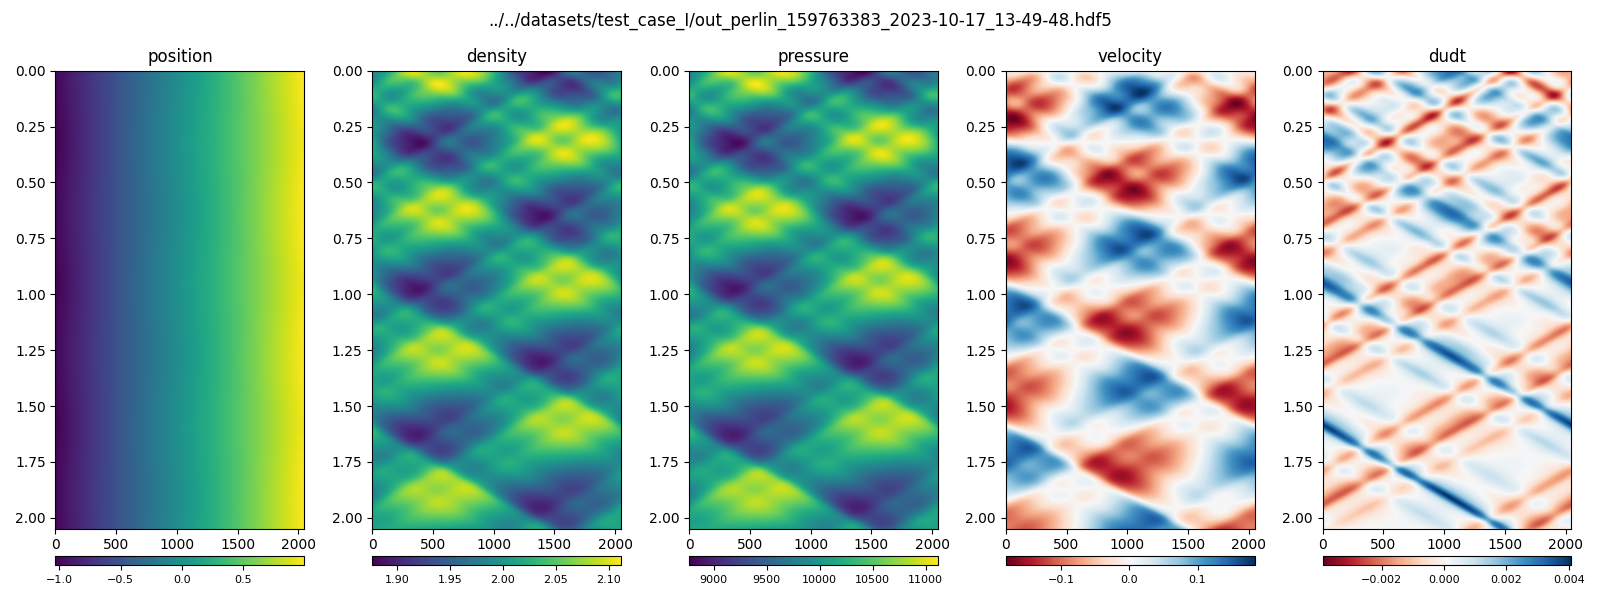

In [5]:
data = loadFile(trainingFiles[0], True)
# plotTrainingFiles(trainingFiles, numParticles, dt,  timesteps)

In [10]:
testingFiles = [f for f in trainingFiles if int(f.split('_')[4]) in [433611252, 960745502, 759352143, 37078787]]
trainingFiles = [f for f in trainingFiles if int(f.split('_')[4]) not in [433611252, 960745502, 759352143, 37078787]]
print(testingFiles)

['../../datasets/test_case_I/out_perlin_960745502_2023-10-17_13-58-43.hdf5', '../../datasets/test_case_I/out_perlin_433611252_2023-10-17_13-52-10.hdf5', '../../datasets/test_case_I/out_perlin_37078787_2023-10-17_13-51-34.hdf5', '../../datasets/test_case_I/out_perlin_759352143_2023-10-17_13-55-08.hdf5']


In [11]:
trainingData = {}
for f in tqdm(trainingFiles):
    trainingData[f] = loadFile(f, False)
testingData = {}
for f in tqdm(testingFiles):
    testingData[f] = loadFile(f, False)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
offset = 16
for f in tqdm(trainingFiles):
    trainingData[f]['stacked'] = getStackedUpdates(trainingData[f]['positions'], trainingData[f]['velocity'], trainingData[f]['dudt'], offset - 1)
for f in tqdm(testingFiles):
    testingData[f]['stacked'] = getStackedUpdates(testingData[f]['positions'], testingData[f]['velocity'], testingData[f]['dudt'], offset - 1)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
normalized = False # rbf normalization
batchSize = 4
maxUnrollsteps = 1
# offset = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
dataSet = []
for f in trainingFiles:
    nSteps = settings[f]['timesteps'] - maxUnrollsteps * (offset - 1)
    for j in range(offset - 1, nSteps):
        dataSet.append((f, j))
print('Dataset contains %d samples [%d files @ %d timesteps]' % (len(dataSet), len(trainingFiles), len(dataSet) / len(trainingFiles)))

Dataset contains 64576 samples [32 files @ 2018 timesteps]


In [14]:
torch.manual_seed('1337')


dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)
# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch

layers = [1]
initialLR = 1e-2
particleData = trainingData
# groundTruthFn = getGroundTruth
# featureFn = getFeatures
lossFn = lossFunction

inputFeatures = 1
seeds = np.random.randint(0, 2**30, 4)

In [15]:
next(dataIter)

[9811, 49981, 46944, 4678]

In [16]:
testCase = 'kernel'

if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics
    
testData = {}
for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures, offset)
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset, particleSupport)

In [17]:
basis = 'rbf square'
window =  None
ns = [6]
widths = [1]
depths = [0]       
seeds = [0]
# runAblationStudyMLPOneLayer('PointNet', 'kernel', [32,32], widths, depths, messages, seeds, device, offset, particleSupport, trainingFiles, particleData, dataSet, testingFiles, testingData, settings)

In [18]:
# ns = [6]
# widths = [1,2,4,8,16,32]
# depths = [0,1,2,3,4,8,16]                
# for basis in tqdm(['fourier odd', 'dmcf', 'abf cubic_spline', 'fourier even', 'linear', 'ffourier', 'chebyshev', 'rbf square']):
#     for window in tqdm([None, 'poly6'], leave = False):
#         for testCase in tqdm(['physicsUpdate'], leave = False):          
#             trainRBFNetwork(basis, testCase, ns, widths, depths, window)

In [19]:
ns = [6]
widths = [1]
depths = [0]       
seeds = [1234567]
# for basis in tqdm(['fourier']):
#     for window in tqdm([None], leave = False):
#         for testCase in tqdm(['kernel'], leave = False):          
dataset = trainRBFNetwork('fourier', 'kernel', ns, widths, depths, seeds, None, device, particleSupport, trainingFiles, trainingData, dataSet, testingFiles, testingData, settings, offset)

display(dataset)
display(dataset['l2'].mean())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,label,seed,window,file,basis,n,entry,params,depth,width,r2,l2,psnr,min,max,q1,q3,std
0,fourier x 6 @ [1],1234567,None,perlin_960745502,fourier,6,0,6,1,1,0.999895,6.664757e-07,68.384417,5.115908e-13,0.000003,1.912482e-07,9.648829e-07,5.052803e-07
1,fourier x 6 @ [1],1234567,None,perlin_960745502,fourier,6,1,6,1,1,0.999814,7.813982e-07,67.524139,2.273737e-13,0.000003,4.166170e-07,1.132672e-06,5.078692e-07
2,fourier x 6 @ [1],1234567,None,perlin_960745502,fourier,6,2,6,1,1,0.999516,6.158493e-07,68.475727,5.684342e-14,0.000003,8.601591e-08,8.931975e-07,7.024866e-07
3,fourier x 6 @ [1],1234567,None,perlin_960745502,fourier,6,3,6,1,1,0.999039,4.677184e-07,69.465361,0.000000e+00,0.000003,6.987914e-08,6.278727e-07,5.934799e-07
4,fourier x 6 @ [1],1234567,None,perlin_433611252,fourier,6,0,6,1,1,0.999962,6.607857e-07,68.498181,1.719513e-12,0.000003,1.636502e-07,9.396402e-07,6.585103e-07
5,fourier x 6 @ [1],1234567,None,perlin_433611252,fourier,6,1,6,1,1,0.999645,7.395701e-07,67.741426,2.273737e-13,0.000003,3.056910e-07,1.115861e-06,5.307997e-07
6,fourier x 6 @ [1],1234567,None,perlin_433611252,fourier,6,2,6,1,1,0.999944,6.563203e-07,68.501864,2.273737e-13,0.000003,1.562134e-07,1.094806e-06,5.884514e-07
7,fourier x 6 @ [1],1234567,None,perlin_433611252,fourier,6,3,6,1,1,0.999925,6.751277e-07,68.261533,0.000000e+00,0.000003,1.103810e-07,9.728622e-07,6.292024e-07
8,fourier x 6 @ [1],1234567,None,perlin_37078787,fourier,6,0,6,1,1,0.999878,6.240925e-07,68.484723,1.421085e-12,0.000003,1.861253e-07,8.594971e-07,5.590272e-07
9,fourier x 6 @ [1],1234567,None,perlin_37078787,fourier,6,1,6,1,1,0.999651,7.673325e-07,67.468344,5.115908e-13,0.000003,3.124835e-07,1.092313e-06,5.453698e-07


6.653148e-07

In [20]:
testCase = 'kernel'
basis = 'fourier'


global testData
if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics

testData = {}
for i in range(len(testingFiles)):
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset, particleSupport)

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
            layouts.append(l)
dataset = pd.DataFrame()

#     for basis in tqdm(bases, leave = False):
dataset = pd.DataFrame()

trainedModel = trainModel(trainingData, testData, settings, dataSet, trainingFiles, fluidFeatures = 3 if testCase == 'physicsUpdate' else 1, offset = offset,
                  n = 8, basis = basis, layers = layouts[0], seed = 1337, particleSupport = particleSupport,
                 window = window, windowNorm = 'integral',
                 epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                 groundTruthFn = groundTruthFn, featureFn = featureFn, lossFn = lossFunction)
#         models.append(trainedModel)
trainedModel['model'].train(False)
df = getTestingLossFrame(trainedModel, testData, plot = False)
dataset = pd.concat([dataset, df])
#                 dataset.to_csv('ablationStudy_%s_%s window %s ns %s ws %s ds %s seeds %s.csv' % (testCase, basis, 'None' if window is None else window, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

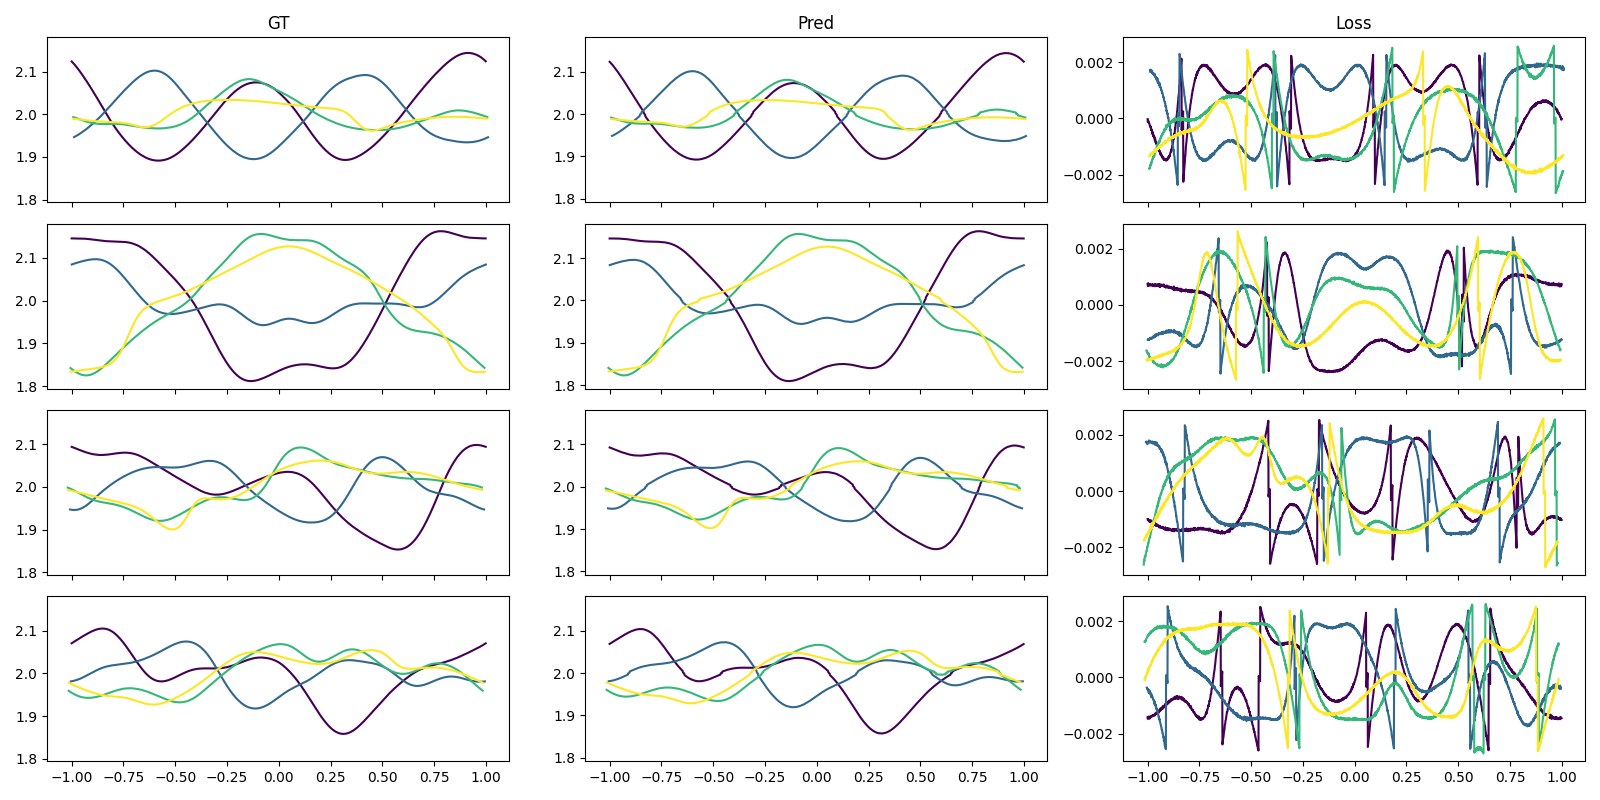

In [21]:
df = getTestingLossFrame(trainedModel, testData, plot = True)